# Obtain Buenos Aires data

# Obtain Oslo data

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from shapely.ops import Point
import geopandas as gpd
import contextily as ctx
import numpy as np
import oslo_lib

import imp 
imp.reload(oslo_lib)

/tmp/ipykernel_63687/3155311494.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'oslo_lib' from '/home/emmanuel/Documents/code/bikesharing/Oslo/oslo_lib.py'>

In [4]:
stations = pd.read_pickle('Oslo/stations.pkl')
stations = oslo_lib.get_geostations(stations)

stations_GPS = stations.geometry.apply(lambda x : [x.x, x.y]).to_list()
station_distances = pd.DataFrame(index=stations.index, 
                                 columns=stations.index, 
                                 data=distance_matrix(stations_GPS, stations_GPS)
                                ).astype(int)

station_distances.to_pickle('Oslo/station_distances.pkl')

if False:  # do you want to recompute processed trips?
    trips = oslo_lib.get_processed_trips(pd.read_pickle('Oslo/trips.pkl'), 
                                         station_distances)
    trips.to_pickle('Oslo/processed_trips.pkl')
else:
    trips = pd.read_pickle('Oslo/processed_trips.pkl')

/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [3]:
trips = pd.read_pickle('Oslo/processed_trips.pkl')

### Trips nature

In [6]:
n_trips = len(trips)
print(n_trips, 'total trips')
n_roundtrips = len(trips[trips.distance==0])
print(n_roundtrips, f'round trips ({np.round(100 * n_roundtrips/n_trips, 1)} %)')

7137700 total trips
201651 round trips (2.8 %)


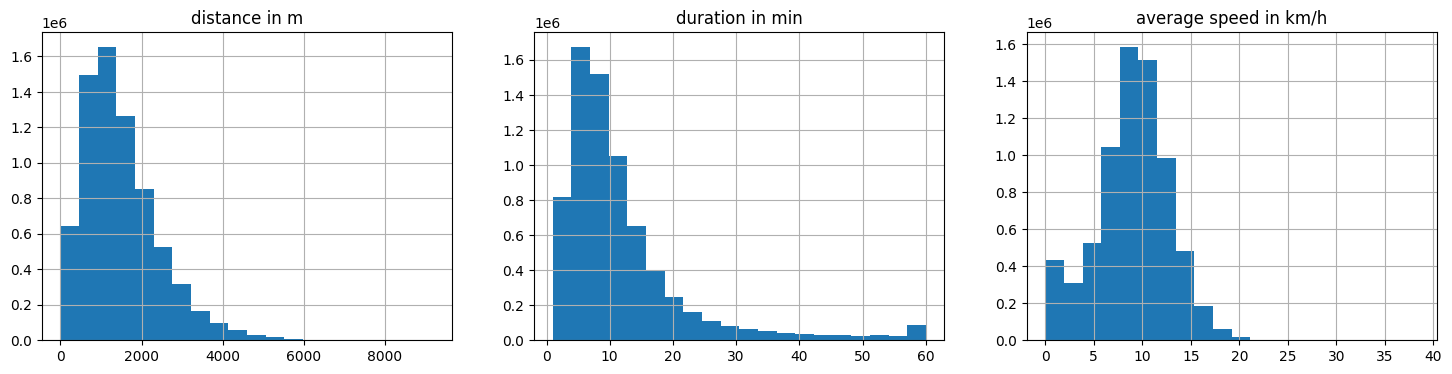

In [7]:
fig, axes = plt.subplots(1,3, figsize=(18,4))
trips.distance.hist(bins=20, ax=axes[0])
axes[0].set_title('distance in m')

trips.duration_min.apply(lambda x : min(x, 60)).hist(bins=20, ax=axes[1])
axes[1].set_title('duration in min')

trips.speed_kmh.hist(bins=20, ax=axes[2])
axes[2].set_title('average speed in km/h')
plt.show()

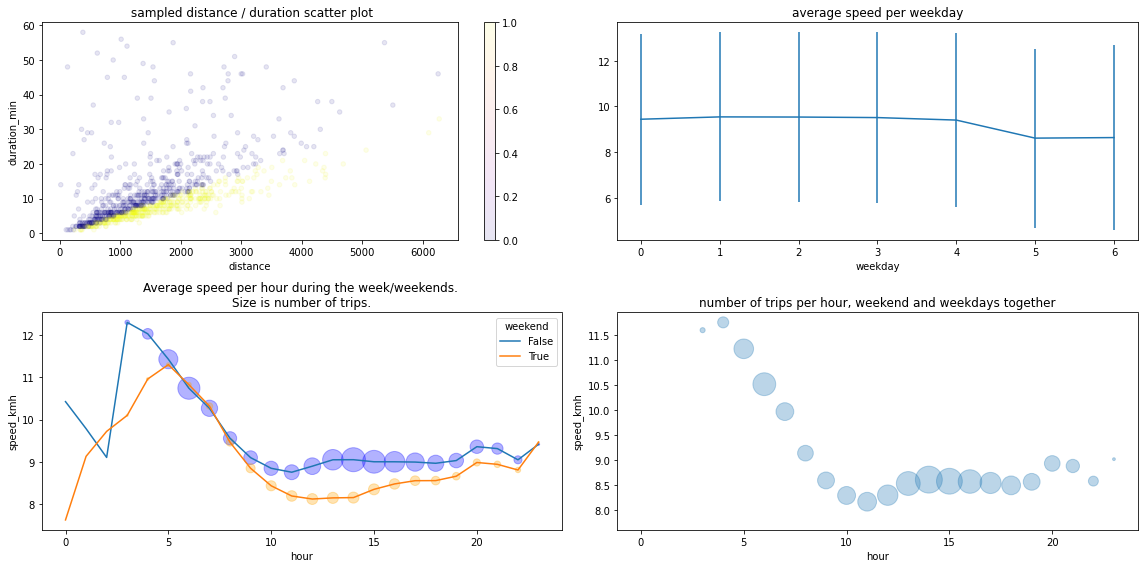

In [9]:
n_points = 1000

fig, axes = plt.subplots(2,2,figsize=(16,8))
axes=axes.flatten()


t = trips.query('duration_min<61 and distance>0')
sample = t.sample(n_points)
sample.plot.scatter(x='distance', 
                    y='duration_min', 
                    c=sample.speed_kmh>10,
                    cmap='plasma',
                    alpha=.1,
                    ax=axes[0], 
                    title=' sampled distance / duration scatter plot',
                    )

t.groupby('weekday').speed_kmh.mean().plot(yerr=trips.groupby('weekday').speed_kmh.std(), 
                                               ax=axes[1], 
                                               title='average speed per weekday')
t.groupby(['hour', 'weekend']).speed_kmh.mean().unstack().plot(ax=axes[2], title='Average speed per hour during the week/weekends. \nSize is number of trips.')
axes[2].grid()

for wk, c in zip([False, True], ['blue', 'orange']):
    t = pd.concat([trips.query('duration_min<61 and distance>0').query(f'weekend == {wk}').groupby('hour').trip.sum(), 
                   trips.query('duration_min<61 and distance>0').query(f'weekend == {wk}').groupby('hour').speed_kmh.mean()], axis=1).reset_index()
    t.plot.scatter(x='hour', 
                   y='speed_kmh', 
                   s = t.trip//1000, alpha=.3, 
                   ax=axes[2],
                  c=c)

t = pd.concat([trips.groupby('hour').trip.sum(), 
               trips.groupby('hour').speed_kmh.mean()], axis=1).reset_index()
t.plot.scatter(x='hour', 
               y='speed_kmh', 
               s = t.trip//1000, alpha=.3, 
               ax=axes[3],
              title='number of trips per hour, weekend and weekdays together')
plt.tight_layout()

### Temporality

<AxesSubplot:xlabel='week'>

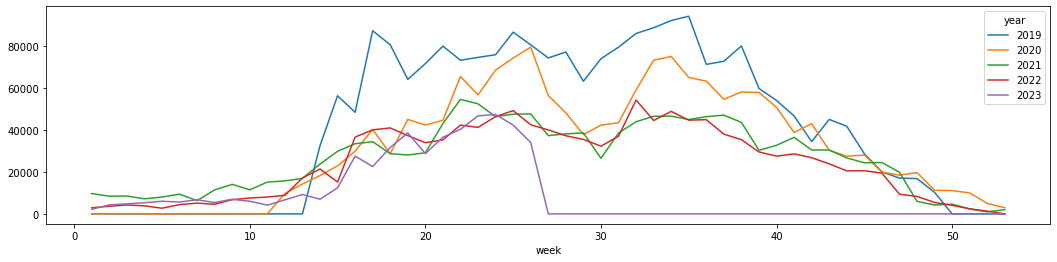

In [7]:
calendar = trips.groupby(['year', 'week']).trip.sum().unstack().fillna(0).astype(int).T
#calendar.style.background_gradient(cmap='Blues')
calendar.plot(figsize=(18,4))

In [8]:
calendar = trips.groupby(['hour', 'weekday']).trip.sum().unstack().fillna(0).astype(int)

day_names = ['M', 'T', 'W', 'Th', 'F', 'St', 'Sn']
calendar.columns = day_names
calendar.style.background_gradient(cmap='Blues')

,M,T,W,Th,F,St,Sn
hour,,,,,,,
0,3,1,1,6,3,33,52
1,3,1,0,0,4,22,42
2,0,0,1,2,2,8,12
3,4147,4478,4617,4416,4391,2202,2240
4,21527,24857,24990,23322,21147,4747,3270
5,66881,79697,80585,75980,67179,9078,6317
6,88439,104304,107770,103421,94493,15026,8412
7,48944,55837,57653,56836,55143,28258,15327
8,34021,35316,37605,38218,38761,40074,23894


In [9]:
yearly_calendar = trips.query('weekend == False').groupby(['year', 'hour', 'weekday']).trip.sum().unstack().mean(axis=1).unstack().T / 1000
yearly_calendar.fillna(0).astype(int).style.background_gradient(cmap='Blues')

year,2019,2020,2021,2022,2023
hour,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,1,1,0,0,0
4,8,5,3,4,1
5,25,15,12,14,5
6,31,19,19,20,7
7,16,11,12,10,4
8,10,8,8,6,2


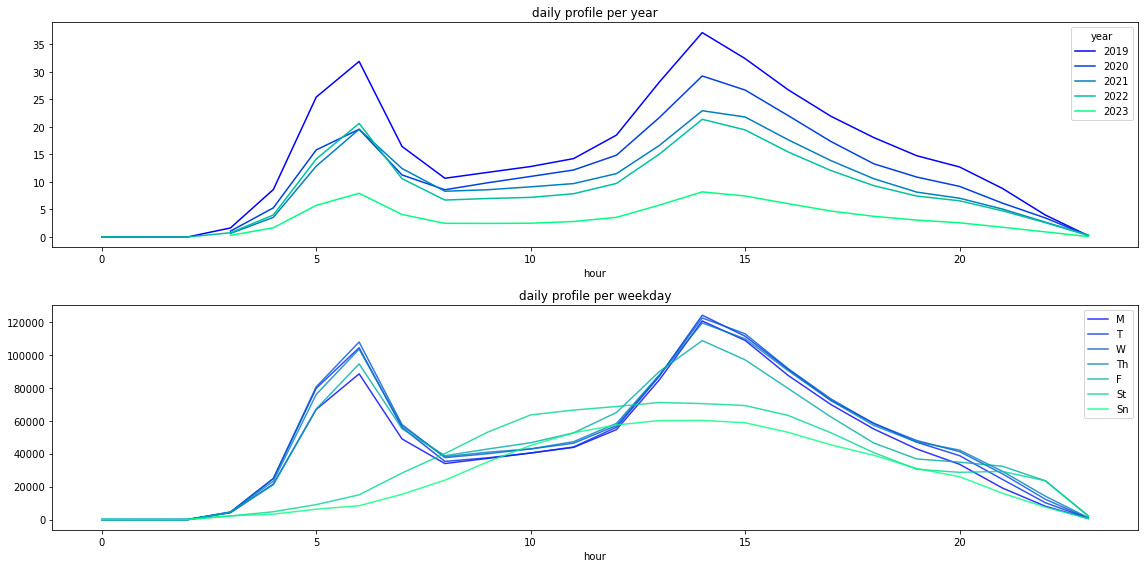

In [10]:
fig, axes = plt.subplots(2, figsize=(16, 8))
yearly_calendar.plot(ax=axes[0], title='daily profile per year', colormap='winter')
calendar.plot(ax=axes[1], colormap='winter', alpha=.8, title='daily profile per weekday')
plt.tight_layout()

<AxesSubplot:xlabel='year'>

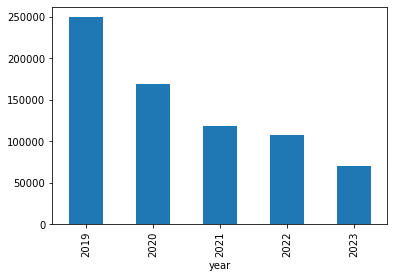

In [11]:
trips.groupby(['year', 'month']).trip.sum().unstack().mean(axis=1).plot.bar()

<AxesSubplot:xlabel='date'>

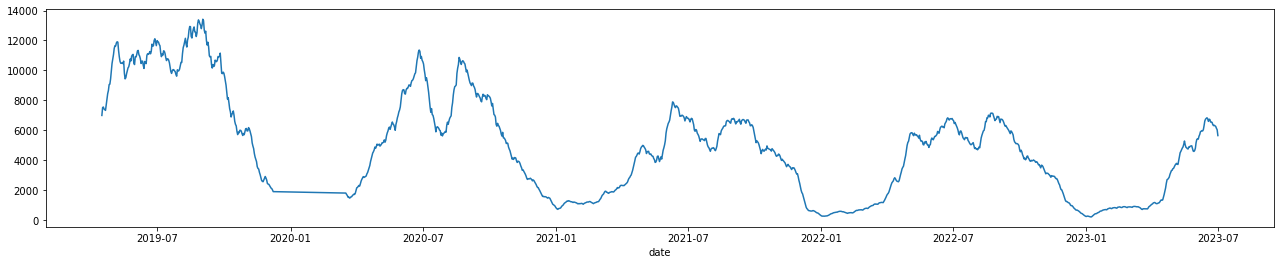

In [12]:
trips.groupby('date').trip.sum().sort_index().fillna(0).rolling(window=15).mean().plot(figsize=(22,4))

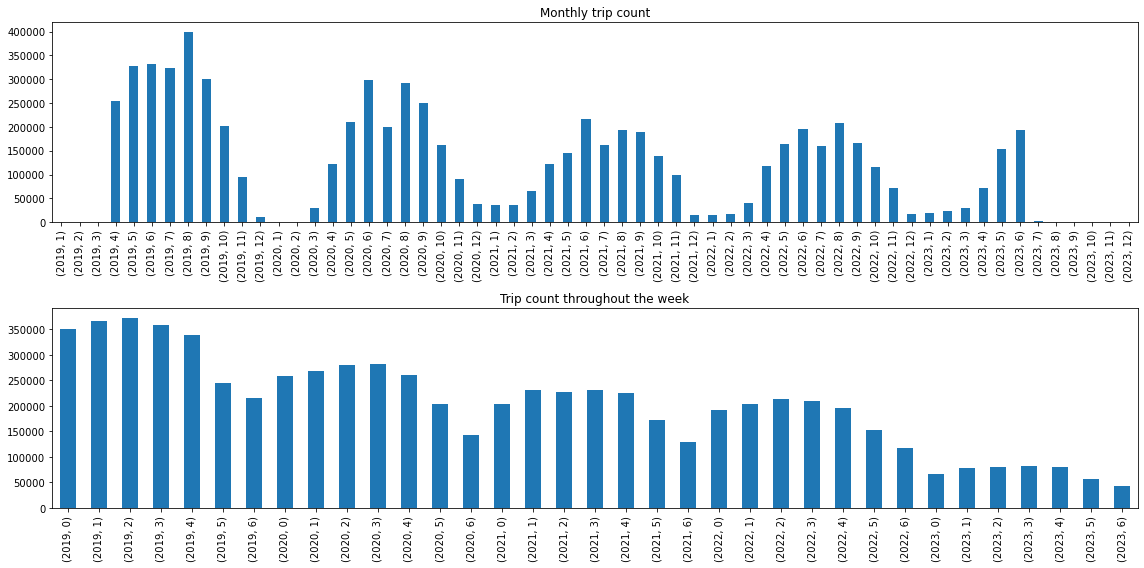

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(16,8))

timeline = pd.MultiIndex.from_product([trips.year.unique(), trips.month.unique()])
trips[['year', 'month']].value_counts().reindex(timeline).sort_index().plot.bar(ax=axes[0], title='Monthly trip count')

timeline = pd.MultiIndex.from_product([trips.year.unique(), trips.weekday.unique()])
trips[['year', 'weekday']].value_counts().reindex(timeline).sort_index().plot.bar(ax=axes[1], title='Trip count throughout the week')

plt.tight_layout()

### Spatiality

In [69]:
distances = distance_matrix(stations_GPS, stations_GPS).flatten()
print('mean inter-station distance in meters:', distances[distances>0].mean())

mean inter-station distance in meters: 2481.8897637620785


<AxesSubplot:title={'center':'distribution of 10k trips per station'}>

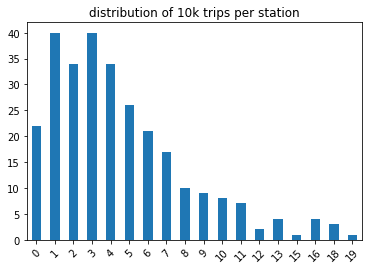

In [77]:
trips_per_station = oslo_lib.get_trips_per_station(trips, stations)
(trips_per_station.trip//1e4).astype(int).value_counts().sort_index().plot.bar(title='distribution of 10k trips per station', 
                                                                               rot=45)

Text(0.5, 1.0, 'number of trips starting/ending at each station')

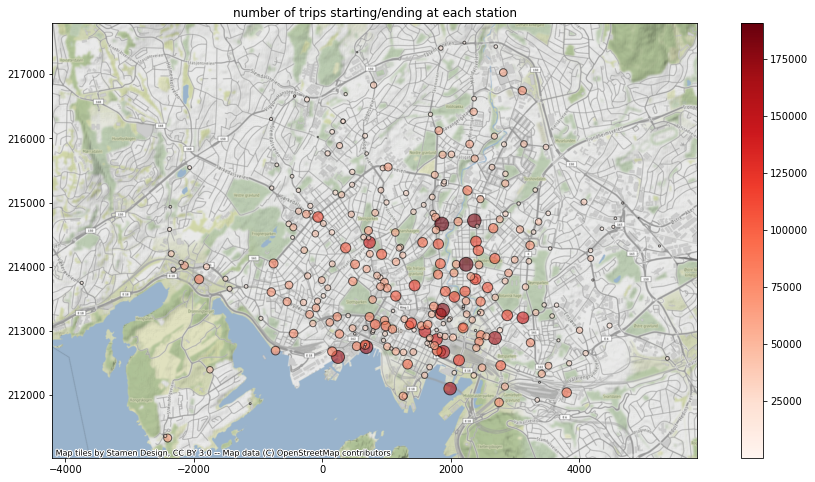

In [83]:
ax = trips_per_station.plot(figsize=(16,8), 
                            edgecolor='k',
                            alpha=.6,
                            cmap='Reds',
                            column=trips_per_station.trip,
                            markersize=trips_per_station.trip/1000,
                            legend=True,
                           )
ctx.add_basemap(ax=ax, crs=trips_per_station.crs)
plt.title('Number of trips starting/ending at each station')

Text(0.5, 1.0, 'Station class in terms of numbr of trips')

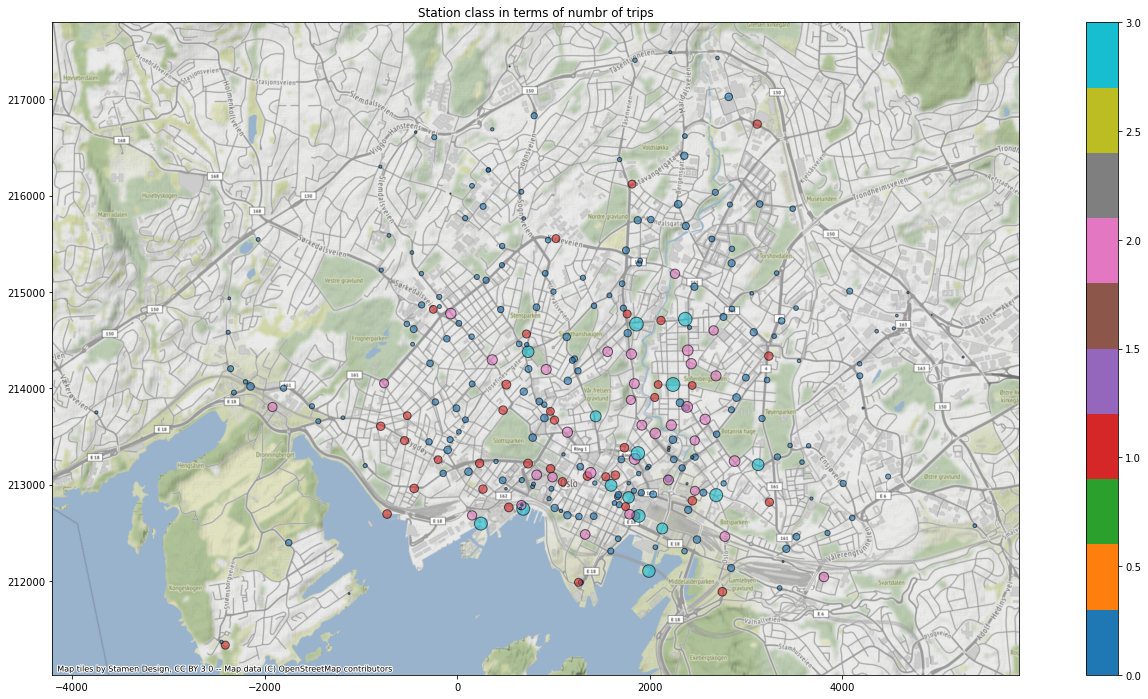

In [84]:
ax = trips_per_station.plot(figsize=(24,12), 
                            edgecolor='k',
                            alpha=.6,
                            cmap='tab10',
                            column='station_class',
                            markersize=trips_per_station.trip/1000,
                            legend=True
                           )
ctx.add_basemap(ax=ax, crs=trips_per_station.crs)
plt.title('Station class in terms of numbr of trips')

In [86]:
trips_per_station.to_pickle('Oslo/trips_per_station.pkl')